In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import netCDF4 as nc
import statsmodels.api as sm
import numpy as np

In [2]:
# read data
gdp_data_path = '/carnegie/data/Shared/Labs/Caldeira Lab/Everyone/'

gdp = pd.read_csv(os.path.join(gdp_data_path, 'gdp_pop_energy_data/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_5447781.csv'), header=2)
# Source for GDP: https://data.worldbank.org/


exp_temp_data_path = '/carnegie/data/Shared/Labs/Caldeira Lab/Everyone/exp_temperature_data/'

cdd_18 = pd.read_excel(os.path.join(exp_temp_data_path, 'Enhanced-Degree-Days-Database-March-2015.xlsx'), sheet_name='t2m.cdd.18C')
hdd_18 = pd.read_excel(os.path.join(exp_temp_data_path, 'Enhanced-Degree-Days-Database-March-2015.xlsx'), sheet_name='T2m.hdd.18C')
# Source for CDD and HDD: https://www.kapsarc.org/research/projects/global-degree-days-database/

frac_people_aggr = pd.read_csv(os.path.join(exp_temp_data_path, 'GDP-vs-agriculture-employment.csv'))
# Source https://ourworldindata.org/grapher/GDP-vs-agriculture-employment

# cdd_18_alt = nc.Dataset(os.path.join(exp_temp_data_path, 'CDD_netcdf/gldas_0p25_deg_cdd_base_T_18C_1970_2018_ann.nc4'))
# Source: https://doi.pangaea.de/10.1594/PANGAEA.903123

ipcc_scenarios = pd.read_csv(os.path.join(exp_temp_data_path, 'ipcc-scenarios.csv'))
# Source: https://ourworldindata.org/explorers/ipcc-scenarios?facet=none&country=SSP1+-+Baseline~SSP2+-+Baseline~SSP3+-+Baseline~SSP4+-+Baseline~SSP5+-+Baseline&Metric=Temperature+increase&Rate=Per+capita&Region=Global

In [3]:
# preprocess data

# Rearrange GDP data
gdp = gdp.set_index('Country Name')
gdp = gdp.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'])
gdp = gdp.stack()
gdp = gdp.reset_index()
gdp.columns = ['Country Name', 'Year', 'GDP']
# Year column is string, convert to int
gdp['Year'] = gdp['Year'].astype(int)
gdp = gdp.set_index(['Country Name', 'Year'])
gdp_world = gdp.loc['World']
# print("GDP world")
# print (gdp_world)

# Rearrange DD data
def rearrange_dd(dd_df, var='CDD'):
    dd_df = dd_df.set_index('Country')
    # Drop rows after Zimbabwe
    dd_df = dd_df.drop(dd_df.index[range(dd_df.index.get_loc('Mean')+1, len(dd_df))])
    #Drop columns that are not years
    dd_df = dd_df.drop(columns=['6 hrs AVERAGE  1964-2013', 'Daily AVERAGE 1964-2013'])
    dd_df = dd_df.stack()
    dd_df = dd_df.reset_index()
    dd_df.columns = ['Country Name', 'Year', var]
    # Convert from 6h to daily frequency
    dd_df[var] = dd_df[var]/4.
    dd_df = dd_df.set_index(['Country Name', 'Year'])
    return dd_df

cdd = rearrange_dd(cdd_18, var='CDD')
cdd_world = cdd.loc['Mean']
hdd = rearrange_dd(hdd_18, var='HDD')
hdd_world = hdd.loc['Mean']
# print("CDD world")
# print (cdd_world)

# Rearrange frac_people_aggr data
frac_people_aggr = frac_people_aggr.set_index(['Entity', 'Year'])
frac_people_aggr = frac_people_aggr['share_employed_agri']
frac_people_aggr_world = frac_people_aggr.loc['World']
# print(frac_people_aggr_world)

# combine data sources
df = pd.concat([gdp_world, cdd_world], axis=1)
df = pd.concat([df, hdd_world], axis=1)
df = pd.concat([df, frac_people_aggr_world], axis=1)
df.dropna(inplace=True)
print(df)

               GDP          CDD          HDD  share_employed_agri
Year                                                             
1991   4414.827055  1457.037175  1684.002467            43.699088
1992   4645.154492  1415.157092  1694.813929            43.474452
1993   4647.739027  1414.446071  1721.156176            42.761867
1994   4940.824175  1440.391394  1642.699128            42.020773
1995   5421.595373  1447.145813  1648.473829            41.115858
1996   5461.773588  1417.331155  1756.211290            40.451693
1997   5364.200785  1444.812071  1651.410798            40.078907
1998   5275.568758  1552.592089  1610.430968            40.052120
1999   5401.497858  1458.211088  1616.928488            40.067430
2000   5507.448927  1457.911885  1629.129194            39.910355
2001   5400.263499  1483.331889  1640.444919            39.570068
2002   5535.408911  1500.754220  1592.917318            39.347629
2003   6127.699308  1523.263606  1681.526924            38.871089
2004   681

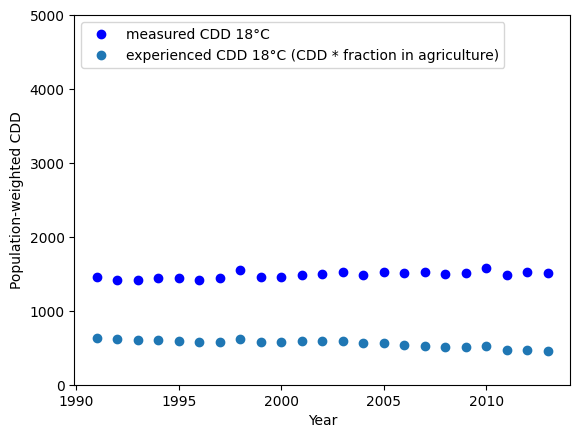

In [4]:
# plot
fig_cdd, ax_cdd = plt.subplots()
# Year vs GDP
ax_cdd.plot(df.index.get_level_values('Year'), df['CDD'], color='b', marker='o', linestyle='None', label='measured CDD 18°C')
# ax.plot(df.index.get_level_values('Year'), df['HDD'], color='r', marker='o', linestyle='None', label='measured HDD 18°C')
ax_cdd.plot(df.index.get_level_values('Year'), df['CDD']*df['share_employed_agri']/100., color='tab:blue', marker='o', linestyle='None', label='experienced CDD 18°C (CDD * fraction in agriculture)')
# ax.plot(df.index.get_level_values('Year'), df['HDD']*df['share_employed_agri']/100., color='tab:red', marker='o', linestyle='None', label='experienced HDD 18°C')
ax_cdd.set_xlabel('Year')
ax_cdd.set_ylabel('Population-weighted CDD')
# ax.set_xlim([1980, 2013])
ax_cdd.set_ylim([0, 5000.])


# Legend at upper right inside plot
ax_cdd.legend(loc='upper left', bbox_to_anchor=(0., 1.0))
# plt.savefig('experienced_CDD.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_1066818/1658169574.py:20: RuntimeWarning: divide by zero encountered in power
  return a * x**(-0.75)


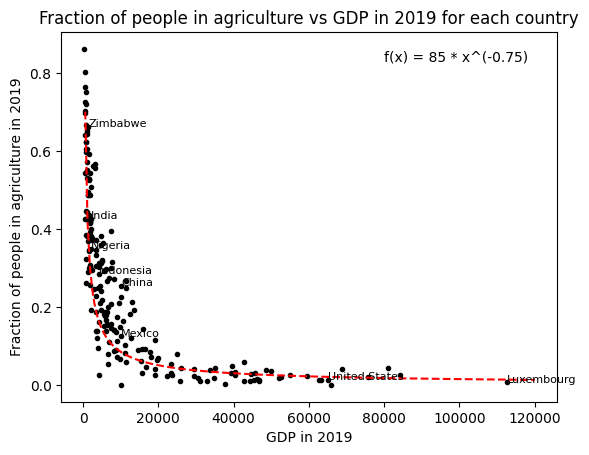

In [14]:
# GDP of all countries in 2021
gdp_2019 = gdp[gdp.index.get_level_values('Year') == 2019]
frac_people_aggr_2019 = frac_people_aggr[frac_people_aggr.index.get_level_values('Year') == 2019]

df_2019 = pd.concat([gdp_2019, frac_people_aggr_2019], axis=1)
df_2019.dropna(inplace=True)
# Add a point for GDP = 0
# df_2019.loc['Zero'] = [0, 100]
df_2019['share_employed_agri'] = df_2019['share_employed_agri']/100.

# Plot GDP vs fraction of people in agriculture
fig, ax = plt.subplots()
ax.plot(df_2019['GDP'], df_2019['share_employed_agri'], color='k', marker='o', markersize=3, linestyle='None')
ax.set_xlabel('GDP in 2019')
ax.set_ylabel('Fraction of people in agriculture in 2019')

# Fit function
from scipy.optimize import curve_fit
def func(x, a):
    return a * x**(-0.75)

# Fit function to data
popt, pcov = curve_fit(func, df_2019['GDP'], df_2019['share_employed_agri'])
plot_x = np.linspace(0, 1.2e5, 200)
ax.plot(plot_x, func(plot_x, *popt), color='r', linestyle='--')

# Print fit function on plot
ax.text(0.65, 0.95, 'f(x) = {:.0f} * x^(-0.75)'.format(popt[0]), transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.title.set_text('Fraction of people in agriculture vs GDP in 2019 for each country')
# Label some points with country names
for country in ['China', 'India', 'United States', 'Indonesia', 'Nigeria', 'Mexico', 'Luxembourg', 'Zimbabwe']:
    ax.text(df_2019.loc[country]['GDP'], df_2019.loc[country]['share_employed_agri'], country, fontsize=8)



# model = sm.OLS(df_2019['share_employed_agri'], df_2019['GDP'])
# result = model.fit()
# print(result.summary())
# print(result.params)
# ax.plot(df_2019['GDP'], result.fittedvalues, color='r', linestyle='--')

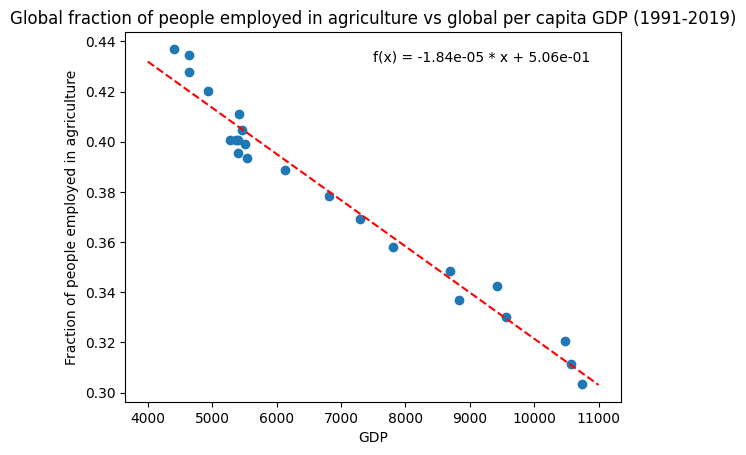

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df['GDP'], df['share_employed_agri']/100.)
ax.set_xlabel('GDP')
ax.set_ylabel('Fraction of people employed in agriculture')

# Fit function
from scipy.optimize import curve_fit
def func(x, a, b):
    return a*x + b

# Fit function to data
popt, pcov = curve_fit(func, df['GDP'], df['share_employed_agri']/100.)
plot_x = np.linspace(4e3, 1.1e4, 200)
ax.plot(plot_x, func(plot_x, *popt), color='r', linestyle='--')
ax.text(0.5, 0.95, 'f(x) = {:.2e} * x + {:.2e}'.format(popt[0], popt[1]), transform=ax.transAxes, fontsize=10, verticalalignment='top')
ax.title.set_text('Global fraction of people employed in agriculture vs global per capita GDP (1991-2019)')

m = popt[0]
b = popt[1]

plt.show()

In [ ]:
# Future projection of experienced CDD

# Drop all columns except Temperature and GDP per capita columns
ipcc_scenarios = ipcc_scenarios[['Scenario','Year', 'Temperature', 'GDP per capita']]
# Only keep SSP1 baseline scenario
ipcc_scenarios = ipcc_scenarios[ipcc_scenarios['Scenario'] == 'SSP3 - Baseline']
# Set index to Scenario and Year
ipcc_scenarios = ipcc_scenarios.set_index(['Scenario', 'Year'])

# Reference CDD as average of 1980-2010
reference_CDD = float(cdd_world.loc[1980:2010].mean())
print(reference_CDD)
# Add CDD predictions for years 2030, 2050 and 2100 matched according to GWL
# source: https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1002/joc.7328 Table 3
ipcc_scenarios.loc[('SSP3 - Baseline', 2030), 'CDD'] = reference_CDD*(1 + 0.8)
ipcc_scenarios.loc[('SSP3 - Baseline', 2050), 'CDD'] = reference_CDD*(1 + 1.5)
ipcc_scenarios.loc[('SSP3 - Baseline', 2070), 'CDD'] = reference_CDD*(1 + 2.65)
ipcc_scenarios.loc[('SSP3 - Baseline', 2100), 'CDD'] = reference_CDD*(1 + 3.72)

# Add experienced CDD predictions
ipcc_scenarios['experienced CDD'] = (ipcc_scenarios['GDP per capita']*m + b) * ipcc_scenarios['CDD']
# Drop rows of years 2005 and 2010
ipcc_scenarios = ipcc_scenarios[ipcc_scenarios.index.get_level_values('Year') != 2005]
ipcc_scenarios = ipcc_scenarios[ipcc_scenarios.index.get_level_values('Year') != 2010]

print(ipcc_scenarios)


1466.6089352055296
                      Temperature  GDP per capita          CDD  \
Scenario        Year                                             
SSP3 - Baseline 2020     1.225753    12659.112288          NaN   
                2030     1.523809    15315.632312  2639.896083   
                2040     1.864192    16697.993205          NaN   
                2050     2.202509    17440.164590  3666.522338   
                2060     2.550932    17975.931011          NaN   
                2070     2.911519    18700.095297  5353.122614   
                2080     3.284348    19489.891331          NaN   
                2090     3.672423    20362.151111          NaN   
                2100     4.071100    21415.380207  6922.394174   

                      experienced CDD  
Scenario        Year                   
SSP3 - Baseline 2020              NaN  
                2030       590.348624  
                2040              NaN  
                2050       676.519004  
              

In [ ]:
# Plot experienced CDD vs Temperature
# Drop scenario index and only keep year index
ipcc_pred = ipcc_scenarios.set_index(ipcc_scenarios.index.get_level_values('Year'))
ipcc_pred = ipcc_pred.drop(columns=['GDP per capita', 'Temperature'])
print(ipcc_pred)

# Drop rows GDP and HDD from dataframe
df_pred = df.drop(columns=['GDP', 'HDD'])
df_pred['experienced CDD'] = df_pred['share_employed_agri'] * df_pred['CDD'] / 100.
df_pred = df_pred.drop(columns=['share_employed_agri'])
pred_df = pd.concat([df_pred, ipcc_pred], axis=0)
print(pred_df)

              CDD  experienced CDD
Year                              
2020          NaN              NaN
2030  2639.896083       590.348624
2040          NaN              NaN
2050  3666.522338       676.519004
2060          NaN              NaN
2070  5353.122614       863.548361
2080          NaN              NaN
2090          NaN              NaN
2100  6922.394174       770.653290
              CDD  experienced CDD
Year                              
1991  1457.037175       636.711956
1992  1415.157092       615.231796
1993  1414.446071       604.843552
1994  1440.391394       605.263604
1995  1447.145813       595.006415
1996  1417.331155       573.334441
1997  1444.812071       579.064890
1998  1552.592089       621.846053
1999  1458.211088       584.267714
2000  1457.911885       581.857814
2001  1483.331889       586.955441
2002  1500.754220       590.511200
2003  1523.263606       592.109149
2004  1483.684693       561.186172
2005  1528.701119       564.564271
2006  1517.545559   

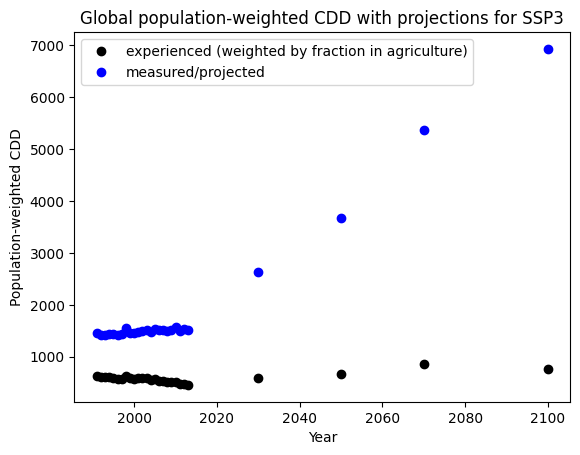

In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_df.index.get_level_values('Year'), pred_df['experienced CDD'], color='k', marker='o', linestyle='None', label='experienced (weighted by fraction in agriculture)')
ax.plot(pred_df.index.get_level_values('Year'), pred_df['CDD'], color='b', marker='o', linestyle='None', label='measured/projected')
ax.set_xlabel('Year')
ax.set_ylabel('Population-weighted CDD')
ax.legend(loc='upper left', bbox_to_anchor=(0., 1.0))
ax.title.set_text('Global population-weighted CDD with projections for SSP3')
plt.show()